<a href="https://colab.research.google.com/github/Omar-Saad/Face-recognition/blob/main/Face_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset from Kaggle

In [ ]:
# Code to read file into Colaboratory:
! pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# upload json file from google drive
link = 'https://drive.google.com/file/d/1P36z2e-mQQod_4NMUshtGNmP6g6lqKDx/view?usp=sharing' # The shareable link
# to get the id part of the file
id = link.split("/")[-2]
  
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('kaggle.json')

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d kasikrit/att-database-of-faces

  0% 0.00/3.61M [00:00<?, ?B/s]
100% 3.61M/3.61M [00:00<00:00, 145MB/s]


In [ ]:
! unzip -q att-database-of-faces.zip -d att-database-of-faces

Non faces read 
---

In [ ]:
! kaggle datasets download -d prasunroy/natural-images

100% 341M/342M [00:02<00:00, 180MB/s]
100% 342M/342M [00:02<00:00, 167MB/s]


In [ ]:
! unzip -q natural-images.zip -d natural-images

# Imports

In [ ]:
! pip install opencv-python

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn
from PIL import Image
import cv2
import sys
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
import random

# Functions
---


*   Read
*   PCA
*   LDA
*   KNN & Tunning



Read function
---

In [ ]:
def read(path,is_faces = True):
  features, labels = [] ,[]
  c = 1
  for dirname, dirnames, filenames in os.walk(path):

    for subdirname in dirnames:
        subject_path = os.path.join(dirname, subdirname)

        for filename in os.listdir(subject_path):
            try:
              if is_faces:
                im = cv2.imread(os.path.join(subject_path, filename),-1 )
              else:
                im = cv2.imread(os.path.join(subject_path, filename),1 )
                down_width = 92
                down_height = 112
                down_points = (down_width, down_height)
                im = cv2.resize(im, down_points)
                im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)


              im = im.flatten()
              features.append(im)
              labels.append(c)
            except IOError as err:
                print ("I/O error({0}): {1}".format(err))
            except:
                print ("Unexpected error:", sys.exc_info()[0])
                raise
        c = c+1

  return features, labels

In [ ]:
def show_images_from_array(features):
  from google.colab.patches import cv2_imshow
  faces = []
  for image in features:
    faces.append(image.reshape(112,92))
  
  Hori = np.concatenate((faces), axis=1) 
  cv2_imshow(Hori)
  cv2.waitKey(0)
  cv2.destroyAllWindows()

PCA
---

In [ ]:
def _PCA(X, alpha=None, num_components=8):
     
    #Step-1 center the data matrix 
    X_meaned = X - np.mean(X , axis = 0)
     
    #Step-2 calculate the convlotion matrix
    cov_mat = np.cov(X_meaned , rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Step-4
    eigen_vectors = eigen_vectors.T
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[sorted_index]
     
    #Step-5 compare alpha with fraction varience
    fraction_varience = 0
    if alpha != None:
      num_components = 0
      for i in sorted_eigenvalue:
        if fraction_varience < alpha:
          fraction_varience += i/sum(sorted_eigenvalue)
          num_components +=1
        else:
          break
          
    #Step-6
    eigenvector_subset = sorted_eigenvectors[0:num_components]
     
    #Step-7
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
    
    print(num_components)
    return X_reduced, num_components, sorted_eigenvalue, sorted_eigenvectors, fraction_varience

In [ ]:
'''
  TODO PCA class
  attributes [projected_matrix, eigen_vector/values, fraction_varience, num_component ]
  constructor take the dataset
  implement fit function take the test/train dataset
'''

'\n  TODO PCA class\n  attributes [projected_matrix, eigen_vector/values, fraction_varience, num_component ]\n  constructor take the dataset\n  implement fit function take the test/train dataset\n'

PCA class
1. Algorithm implementaion of PCA
2. update function to update the number of component to be used
3. Transform function to project the dataset 

In [ ]:
class PCA:
    def __init__(self, X ,alpha=None ,num_components=8):

      self.num_components = num_components
      self.X_meaned = X - np.mean(X, axis=0)

      cov_mat = np.cov(self.X_meaned , rowvar = False)
      eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
      
      eigen_vectors = eigen_vectors.T
      sorted_index = np.argsort(eigen_values)[::-1]
      self.sorted_eigenvalue = eigen_values[sorted_index]
      self.sorted_eigenvectors = eigen_vectors[sorted_index]

      if alpha:
        self.update_num_component(alpha)
        
    def update_num_component(self, alpha=None):
      fraction_varience = 0

      if alpha != None: 
        self.num_components = 0
        for i in range(len(self.sorted_eigenvalue)):
          if fraction_varience < alpha:
            # fraction_varience += i/sum(self.sorted_eigenvalue)
            fraction_varience = sum(self.sorted_eigenvalue[:i])/sum(self.sorted_eigenvalue)
            self.num_components +=1
          else:
            return self.num_components
            # take only r dimesions (num_components)
            break

    def transform(self, x):
      return np.dot(x, self.sorted_eigenvectors[0:self.num_components].T)

    def projection_mat(self):
      return self.sorted_eigenvectors[0:self.num_components]



LDA
---

LDA class 
1. Algorithm implementaion of LDA 
2. Transform function to project the dataset

In [ ]:
class LDA:
  def __init__(self, X, y):
    class_labels = np.unique(y)
    n_features = X.shape[1]

    mean_overall = np.mean(X, axis=0)
    SW = np.zeros((n_features, n_features))
    SB = np.zeros((n_features, n_features))

    for c in class_labels:
      X_c = X[y == c]
      mean_c = np.mean(X_c, axis=0)

      n_c = X_c.shape[0]
      mean_diff = (mean_c - mean_overall).reshape(n_features, 1)
      SB += n_c * (mean_diff).dot(mean_diff.T)

      X_meaned = X_c - mean_c
      SW = X_meaned.T.dot(X_meaned)

    SW_inv = np.linalg.inv(SW)

    eigen_values , eigen_vectors = np.linalg.eigh(SW_inv.dot(SB))
    #print("Eigen Vector size : ",len(eigen_vectors))
    eigen_vectors = eigen_vectors.T
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    self.sorted_eigenvectors = eigen_vectors[sorted_index]

  def transform(self, X, num_components):
    # returns projected matrix
    return np.dot(X, self.sorted_eigenvectors[0:num_components].T)
    

KNN
---

In [ ]:
def results_format(classifier_name, accuracy):
  
    print(f"Accuracy = {accuracy}")
    print("-------------------------------------------------------------------------------------")

classes = np.arange(1,41)
def modeling(clf, classifier_name, x_train, y_train, x_test, y_test):

    clf.fit(x_train, y_train)
    predictions = clf.predict(x_test)
    # print("Pred : ")
    # print(predictions==y_test)

    """
    CM = | TN FP |
         | FN TP |
    """
    cm = confusion_matrix(y_test, predictions)
    # df_cm = pd.DataFrame(cm, index = [i for i in classes], columns = [i for i in classes])
    
    accuracy = accuracy_score(predictions, y_test)


    # Plot confusion_matrix  heatmap
    print("Confusion Matrix : ")
    print(cm)
    # plt.figure(figsize = (12,7))
    # sn.heatmap(df_cm, annot=True)
    results_format(classifier_name, accuracy)
    return accuracy

In [ ]:
def knn(k, x_train, y_train, x_test, y_test):
  clf = KNeighborsClassifier(n_neighbors=k)
  accuracy = modeling(clf, "K-Nearest Neighbors", x_train, y_train, x_test, y_test)
  return clf, accuracy

KNN tunning using Cross_validation and stratified k_folds to split balanced folds

In [ ]:
def plot_tuning_parameter(x, y, title, x_label, y_label):
   plt.title(title, fontsize='16')  # title
   plt.plot(x, y, marker='o')  # plot the points
   plt.xlabel(x_label, fontsize='13')  # adds a label in the x axis
   plt.ylabel(y_label, fontsize='13')  # adds a label in the y axis
   plt.grid()  # shows a grid under the plot
   plt.show()

def get_best_k(train_features,train_labels):
    k_range = [1,3,5,7]
    k_scores = []
    skf = StratifiedKFold(n_splits=5)
    for k in k_range:
        clf = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(clf, train_features, train_labels, cv=skf, scoring='accuracy')
        k_scores.append(scores.mean())
    plot_tuning_parameter(k_range, k_scores, "K for K-Nearest Neighbor", "K-values", "Mean-Accuracy")
    # return (k_scores.index(max(k_scores))) + k_range[0]
    
    return k_range[(k_scores.index(max(k_scores)))] 

In [ ]:
# def knn(k):
#   clf = KNeighborsClassifier(n_neighbors=k)
#   return clf

# Main

Read Dataset
---

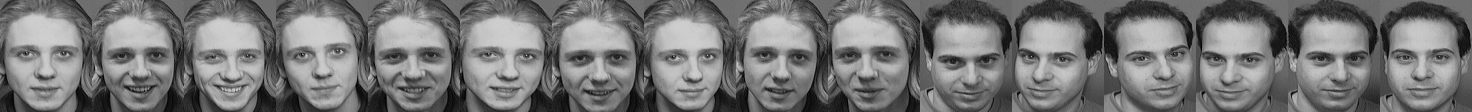

In [ ]:
features, labels = read('att-database-of-faces')
show_images_from_array(features[0:16])
# print(len(features[0]))

Convert to numpy array
---

In [ ]:
features = np.array(features)
labels = np.array(labels)

Split Data
---

In [ ]:
# Train even col.
x_train = features[0::2]
y_train = labels[0::2]
# Test odd col.
x_test = features[1::2]
y_test = labels[1::2]

# X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.5, stratify=labels)

Scaling Features
---

In [ ]:
# sc = StandardScaler()
# x_train = sc.fit_transform(x_train)
# x_test = sc.transform(x_test)

Run PCA
---

In [ ]:
pca_train = PCA(x_train)

In [ ]:
# pca_test = PCA(x_test)

Runnig PCA with diffrent alpha and classifing using Knn with diffrent K's
```
alpha = [0.8, 0.85, 0.9, 0.95]
k_array = [1,3,5,7]
```



For alpha =  0.8  : 
Number Of components =  35
Resulted Vector (After Reduction) : 
(200, 10304)

Performance Measures For Alpha =  0.8


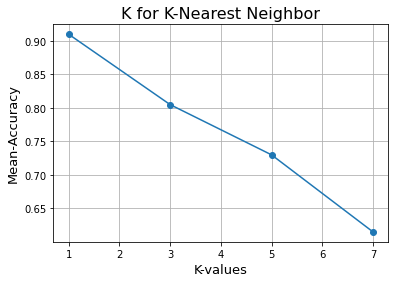

Applying KNN with K (best k for this apha) =  1
Confusion Matrix : 
[[5 0 0 ... 0 0 0]
 [0 4 1 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 4]]
Accuracy = 0.95
-------------------------------------------------------------------------------------
===========END==========================
For alpha =  0.85  : 
Number Of components =  50
Resulted Vector (After Reduction) : 
(200, 10304)

Performance Measures For Alpha =  0.85


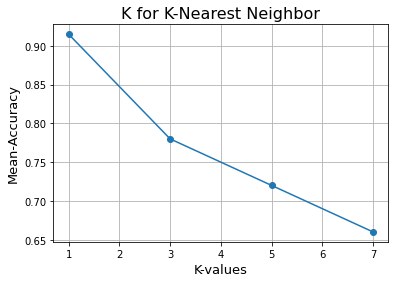

Applying KNN with K (best k for this apha) =  1
Confusion Matrix : 
[[5 0 0 ... 0 0 0]
 [0 4 1 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 4]]
Accuracy = 0.95
-------------------------------------------------------------------------------------
===========END==========================
For alpha =  0.9  : 
Number Of components =  74
Resulted Vector (After Reduction) : 
(200, 10304)

Performance Measures For Alpha =  0.9


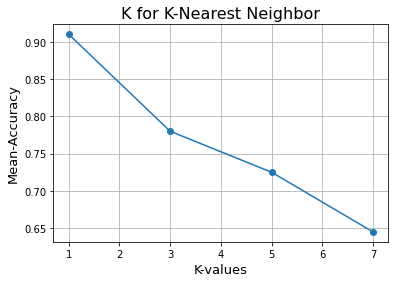

Applying KNN with K (best k for this apha) =  1
Confusion Matrix : 
[[5 0 0 ... 0 0 0]
 [0 4 1 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 4]]
Accuracy = 0.94
-------------------------------------------------------------------------------------
===========END==========================
For alpha =  0.95  : 
Number Of components =  114
Resulted Vector (After Reduction) : 
(200, 10304)

Performance Measures For Alpha =  0.95


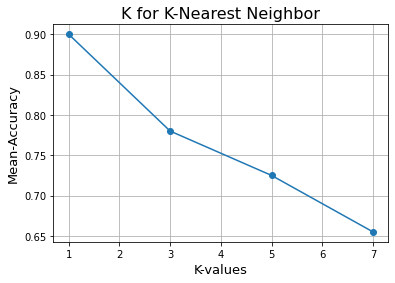

Applying KNN with K (best k for this apha) =  1
Confusion Matrix : 
[[5 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 4 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 4]]
Accuracy = 0.935
-------------------------------------------------------------------------------------
===========END==========================


In [ ]:
alpha = [0.8, 0.85, 0.9, 0.95]
k_array=[1,3,5,7]
model = []
accuracy = []
max_accuracy = []
k_acc = []

pca_train_reduced = []
pca_test_reduced = []


for i in range(len(alpha)):
  accuracy = []
  pca_train.update_num_component(alpha[i])

  x_test_proj  = pca_train.transform(np.array(x_test))
  x_train_proj  = pca_train.transform(np.array(x_train))

  pca_train_reduced.append(x_train_proj)
  pca_test_reduced.append(x_test_proj)

  print("For alpha = ",alpha[i]," : ")
  print("====================")
  print("Number Of components = ",pca_train.num_components)
  print("Resulted Vector (After Reduction) : ")
  print(x_test.shape)
  print()

  print("Performance Measures For Alpha = ",alpha[i])
  print("=======================================")

  k = get_best_k(x_train_proj,y_train)
  
  print("Applying KNN with K (best k for this apha) = ",k)
  clf ,acc = knn(k, x_train_proj, y_train, x_test_proj, y_test)
  model.append(clf)
  max_accuracy.append(acc)
  # k_acc.append(acc)
  
  # for k in k_array:
  #   print("For K = ",k," :")
  #   clf ,acc = knn(k, x_train_proj, y_train, x_test_proj, y_test)
  #   accuracy.append(acc)
  #   if k==k_array[-1]:
  #     max_accuracy.append(max(accuracy))
  # plt.plot(k_array, accuracy, marker='o')
  
  print("===========END==========================")
  


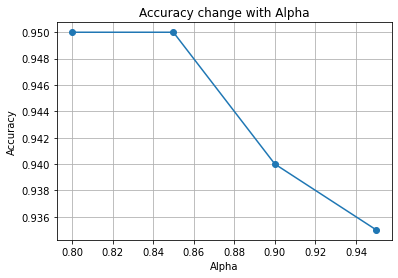

In [ ]:
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.title("Accuracy change with Alpha")
plt.grid()
plt.plot(alpha, max_accuracy, marker ='o')

LDA RUN
---

In [ ]:
lda_train = LDA(x_train, y_train)

In [ ]:
# lda_test = LDA(x_test, y_test)

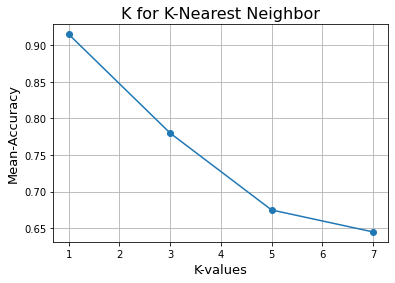

Applying KNN with K (best k) =  1
Confusion Matrix : 
[[5 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 4 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]]
Accuracy = 0.945
-------------------------------------------------------------------------------------


In [ ]:
x_train_proj = lda_train.transform(x_train, 39)
x_test_proj = lda_train.transform(x_test, 39)


k = get_best_k(x_train_proj,y_train)
print("Applying KNN with K (best k) = ",k)

model = knn(k, x_train_proj, y_train, x_test_proj, y_test)

# Observation and Conclusion
---

Both PCA and LDA looks for linear combinations of the features which best explain the data.
---
* LDA focuses on finding a feature subspace that maximizes the separability between the groups.
* PCA focuses on capturing the direction of maximum variation in the data set.




We get better result with PCA than LDA in this case
---

# PCA analysis


Relation between alpha and number of commponents
---
Number of commponents increased with alpha to increses accuracy

Relation between alpha and accuracy.
---
Accuracy increases as we increase alpha thats becases the number of eign_vectors used increased

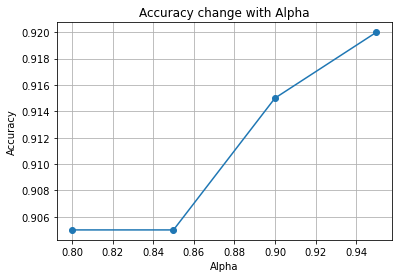

Relation between number of k and accuracy
---
As we increases the number of K the accuracy decreases with all diffrent values of alpha.

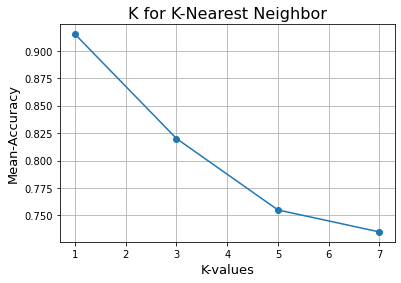

# LDA analysis

Relation between number of k and accuracy
---
Accuracy decreases with the increase of number of K.

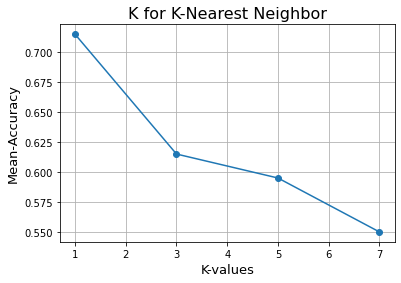

**We can generalize that the accuracy decreases with large K**
---

# Face VS Non-Face

Read Non-face imgs
---

In [ ]:
features2, labels2 = read('natural-images/natural_images',False)

sample random images

In [ ]:
sampled_list = random.sample(features2, 400)

Split
---

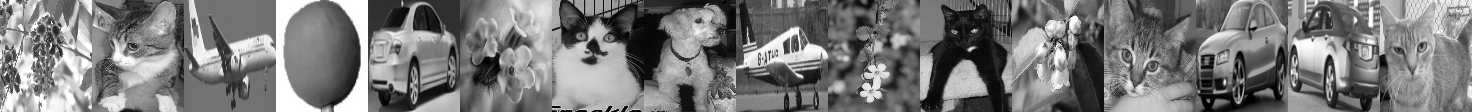

In [ ]:
sampled_list = np.array(sampled_list[:400])
labels2 = labels2[:400] 
x = np.concatenate((np.array(sampled_list),np.array(features)))
y = np.concatenate((np.array(labels2),np.array(labels)))

show_images_from_array(x[0:16])

In [ ]:
y[:400] = 0
y[400:] = 1
X_train, X_test, Y_train, Y_test = train_test_split(x, y, train_size=0.5, stratify=y)

# print(labels2)

LDA RUN
---

In [ ]:
lda2 = LDA(np.array(X_train), np.array(Y_train))

In [ ]:
x_train_proj2 = lda2.transform(X_train, 1)
x_test_proj2 = lda2.transform(X_test, 1)
#print(len(x_train_proj2[0]))

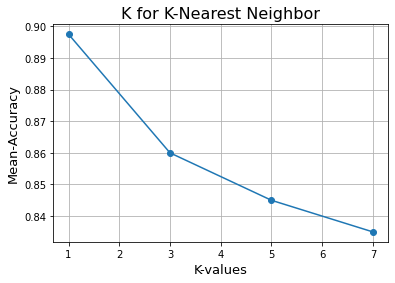

Applyinng KNN with k =  1
Confusion Matrix : 
[[168  32]
 [  0 200]]
Accuracy = 0.92
-------------------------------------------------------------------------------------


(KNeighborsClassifier(n_neighbors=1), 0.92)

In [ ]:
k = get_best_k(X_train,Y_train)
print("Applyinng KNN with k = ",k)
knn(k,X_train, Y_train,X_test, Y_test)
# print("Test : ")
# print(Y_test)

# Observation and Conclusion


1.   We tried LDA with diffrent number of eigenvectors and discovered that the accuracy doesn't change so sticked with 1 eigenvector to avoide high dimensions.
2. Using large number of non-faces in training make the model biased toward the non-face without using LDA.
3. But using wont make the model biased because LDA maximizes the separability between the groups

